# Tarea PCA

Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(predicciones, y_test):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.2f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def n_principal_components(X, n_var):
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('pca', PCA())
          ])

     pipeline.fit(X)

     objeto_pca = pipeline.named_steps['pca']
     X_pca = pipeline.transform(X)
     X_componentes = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

     plt.bar(range(1, n_var+1), objeto_pca.explained_variance_ratio_[:n_var], color=colors[0])
     for i in range (n_var):
          plt.text(i+1, objeto_pca.explained_variance_ratio_[i] - 0.01, f'{objeto_pca.explained_variance_ratio_[i]:.4f}', ha='center', va='center', fontweight='bold')
     plt.xlabel('Componentes principales')
     plt.ylabel('Varianza explicada')
     plt.title(f'Varianza explicada de los {n_var} componentes principales')
     plt.show()

     return X_componentes

def xgboost(X_train, X_test, y_train, y_test):
    model = XGBRegressor(n_estimators=10000, max_depth=5, learning_rate=0.1, reg_lambda=0.1, 
                          subsample=0.5, colsample_bytree=0.8, tree_method='hist', gamma=0.1
                          )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=20)

    predicciones = model.predict(X_test)
    r2 = r2_score(y_test, predicciones)

    calibracion(predicciones, y_test)

    importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
    importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

    # Separar nombres y valores
    features_weight = list(importancia_weight_dict.keys())
    valores_weight = list(importancia_weight_dict.values())

    features_gain = list(importancia_gain_dict.keys())
    valores_gain = list(importancia_gain_dict.values())

    importance(features_weight, valores_weight, 5, 'weight')
    importance(features_gain, valores_gain, 5, 'gain')

    return print(f'R2: {r2:.4f}')

def n_components_scatterplot(X_componentes, comp1, comp2):
     plt.scatter(X_componentes[comp1], X_componentes[comp2], color=colors[0])
     plt.xlabel(comp1)
     plt.ylabel(comp2)
     plt.title('Distribución de los datos en el espacio de componentes principales')
     plt.show()

def codo(data):
    data = data.copy().dropna()

    inertias = []
    for i in range(1, 11):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(inertias, marker='o', color = colors[0])
    plt.title('Método del codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.show()

def clusters(data, X_componentes, clusters, comp1, comp2):
    data = data.copy().dropna()
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=clusters, random_state=42))
    ])
    pipeline.fit(data)
    X_componentes['cluster'] = pipeline.predict(data)

    for cluster_id in X_componentes['cluster'].unique():
        cluster_data = X_componentes[X_componentes['cluster'] == cluster_id]
        plt.scatter(cluster_data[comp1], cluster_data[comp2], 
                    label=f'Cluster {cluster_id}', color=colors[cluster_id+1])
    plt.xlabel(comp1)
    plt.ylabel(comp2)
    plt.title('Distribución de los datos en el espacio de componentes principales')
    plt.legend()
    plt.show()

# Data

In [3]:
data = pd.read_csv("Data/Hitters.csv")
data = pd.get_dummies(data)
data = data.fillna(data.mean())
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,...,446,33,20,535.925882,True,False,True,False,True,False
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.000000,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.000000,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.000000,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.500000,False,True,True,False,False,True


## Variable dependiente

In [4]:
target = 'Salary'
y = data[target]

## Variables independientes

In [5]:
X = data.copy().drop(target, axis=1)

# Varianza de las primeras 3 componentes

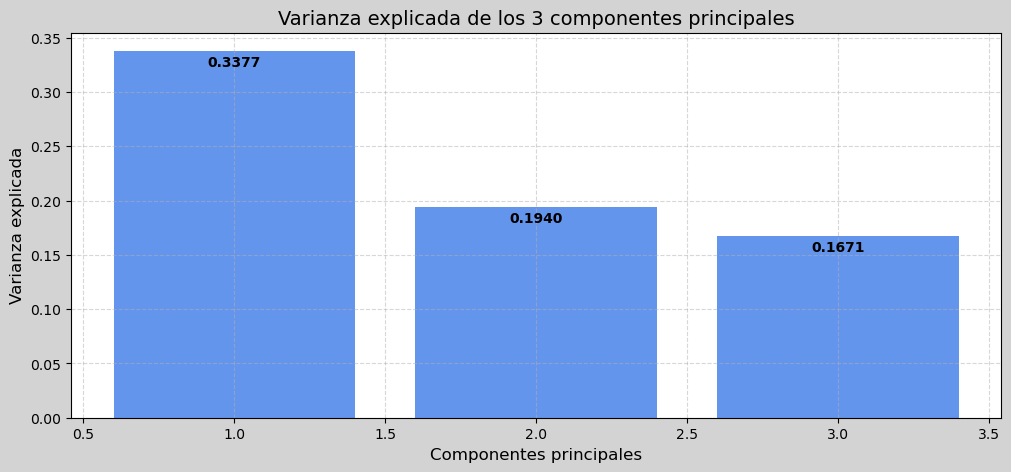

In [6]:
X_componentes = n_principal_components(X, 3)

# KMeans 2 componentes principales

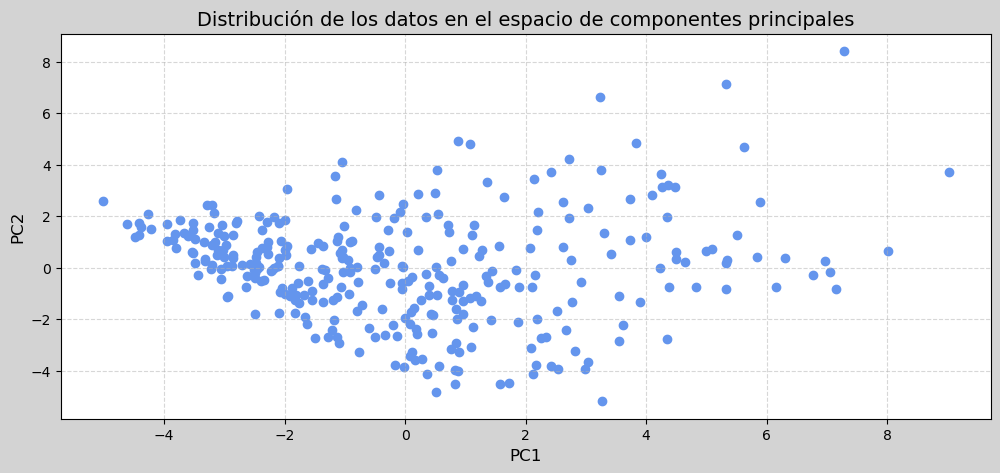

In [7]:
n_components_scatterplot(X_componentes, 'PC1', 'PC2')

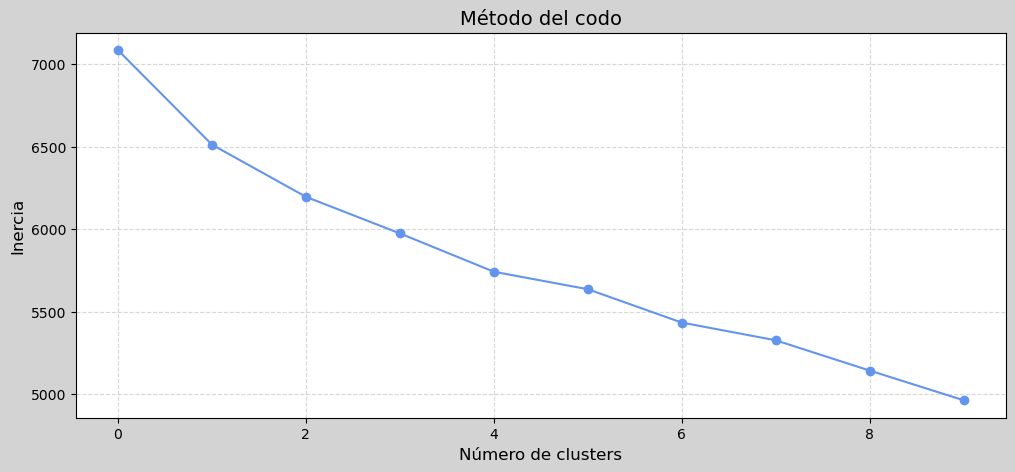

In [8]:
codo(X_componentes)

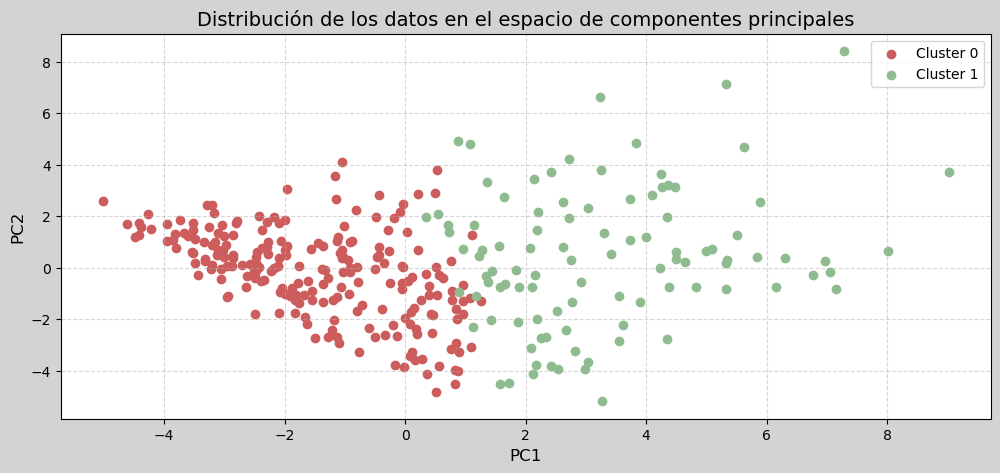

In [9]:
clusters(X, X_componentes, 2, 'PC1', 'PC2')

# Boosting Model

## Todas las variables

[0]	validation_0-rmse:604.68944	validation_1-rmse:662.60237
[58]	validation_0-rmse:79.47039	validation_1-rmse:331.73971


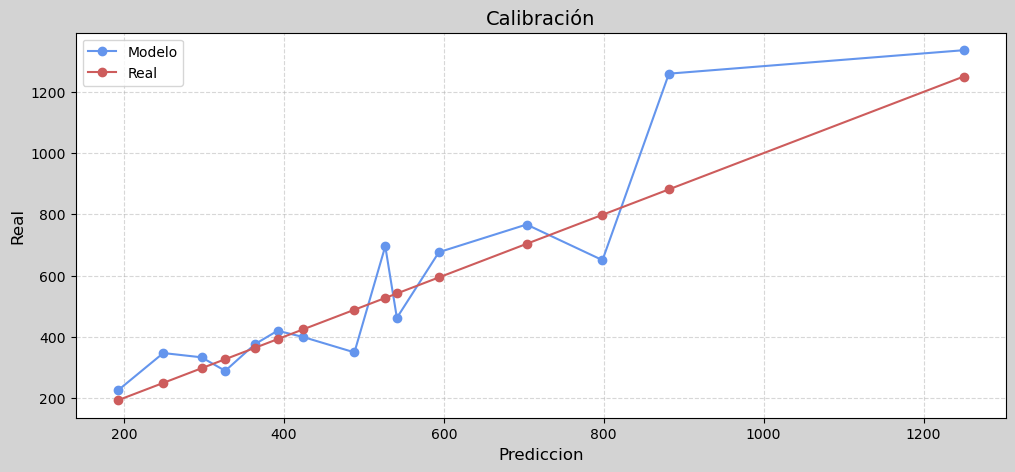

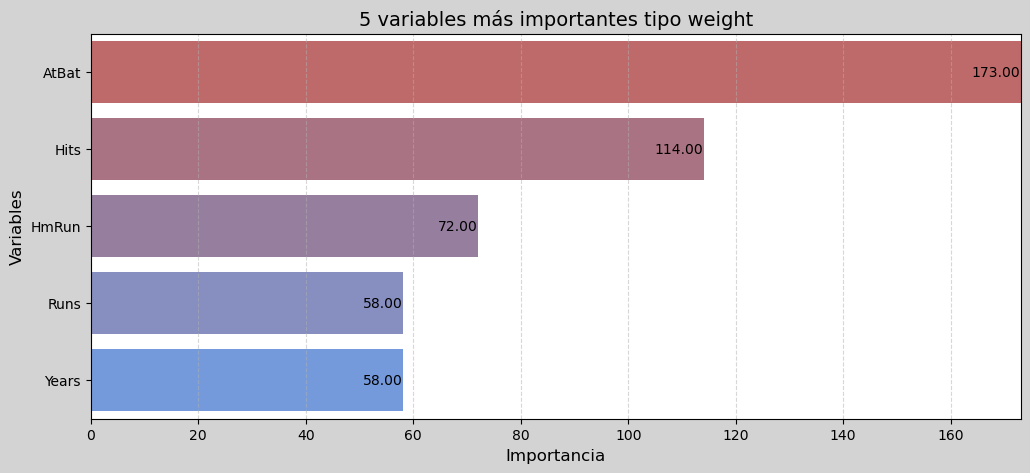

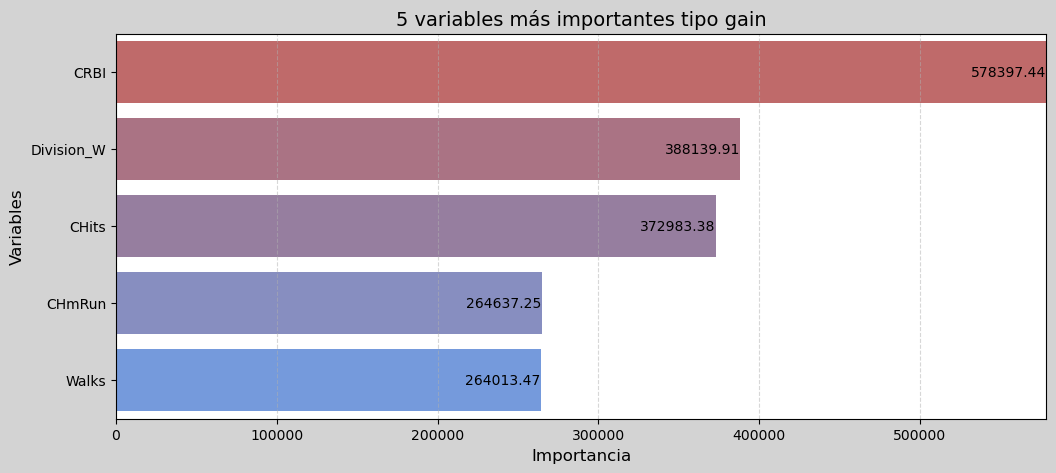

R2: 0.4292


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost(X_train, X_test, y_train, y_test)

## Todos los componentes

[0]	validation_0-rmse:604.83338	validation_1-rmse:668.47929
[68]	validation_0-rmse:60.33325	validation_1-rmse:324.95865


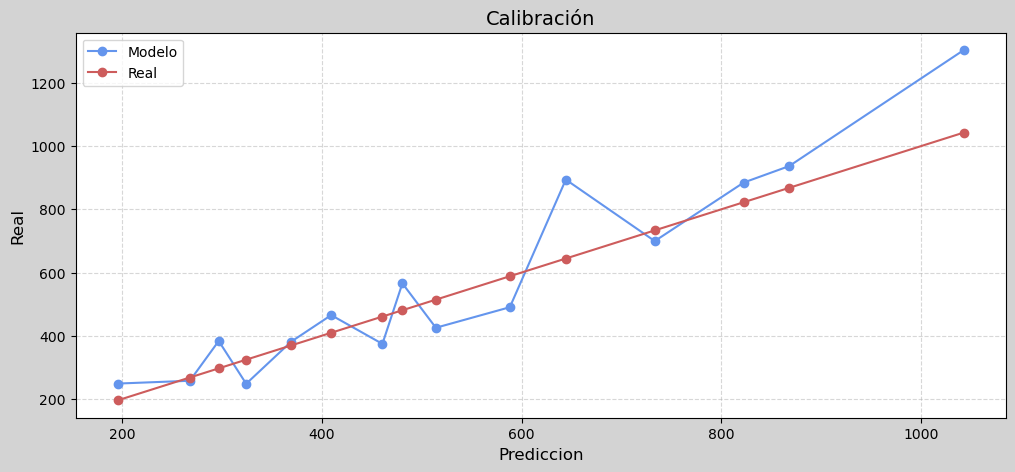

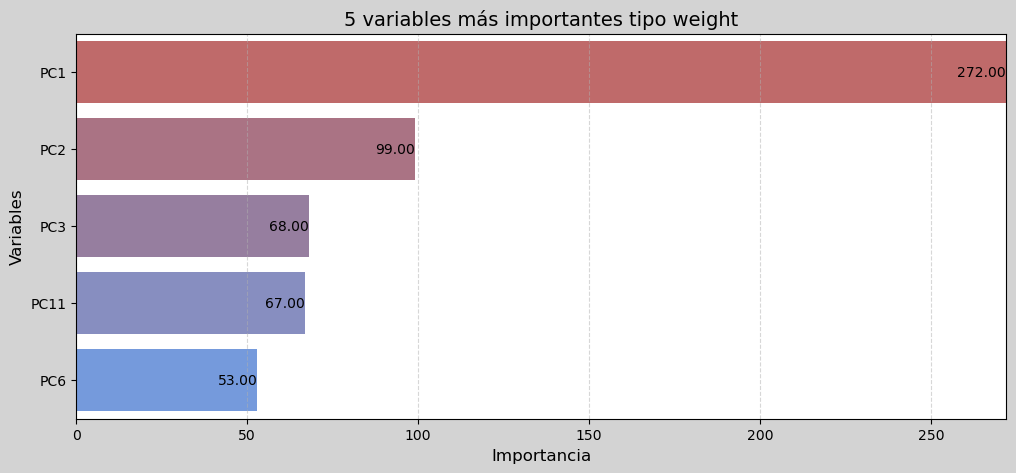

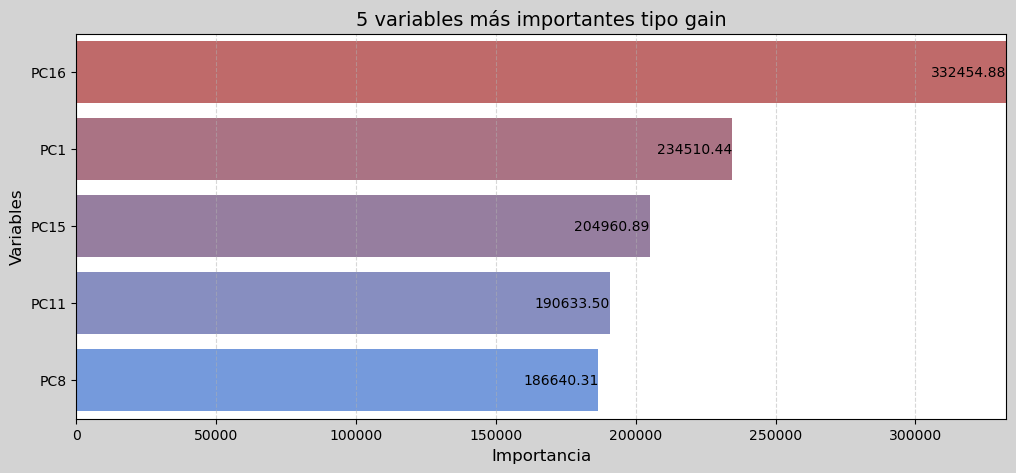

R2: 0.4504


In [11]:
XC_train, XC_test, y_train, y_test = train_test_split(X_componentes, y, test_size=0.2, random_state=42)

xgboost(XC_train, XC_test, y_train, y_test)

## 3 principales componentes

[0]	validation_0-rmse:609.22119	validation_1-rmse:682.50742
[60]	validation_0-rmse:114.71855	validation_1-rmse:368.74525


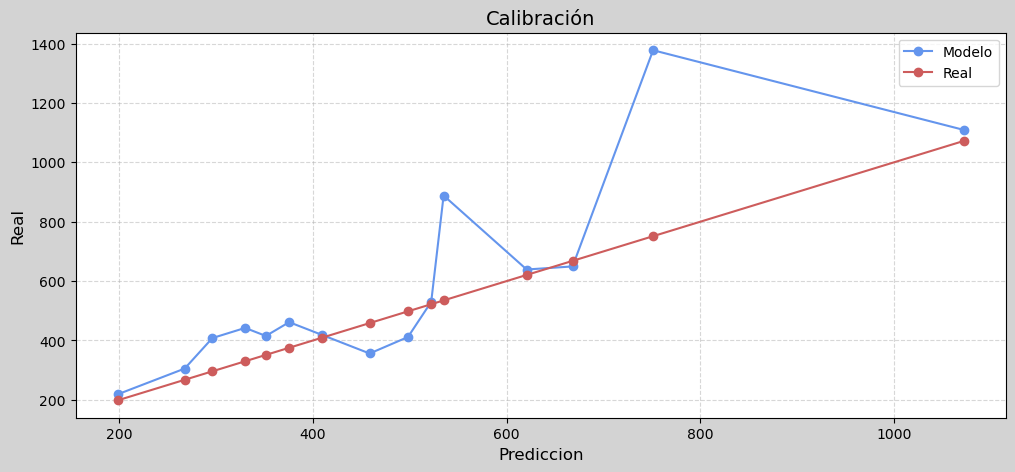

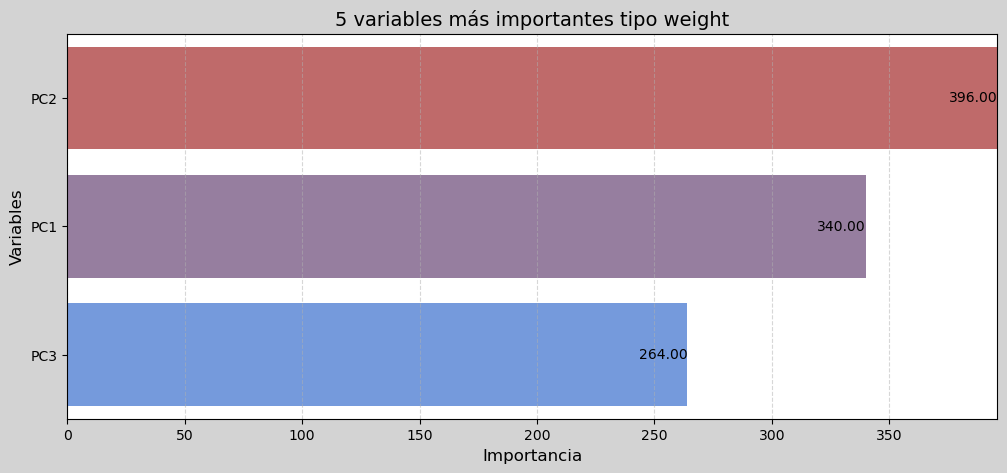

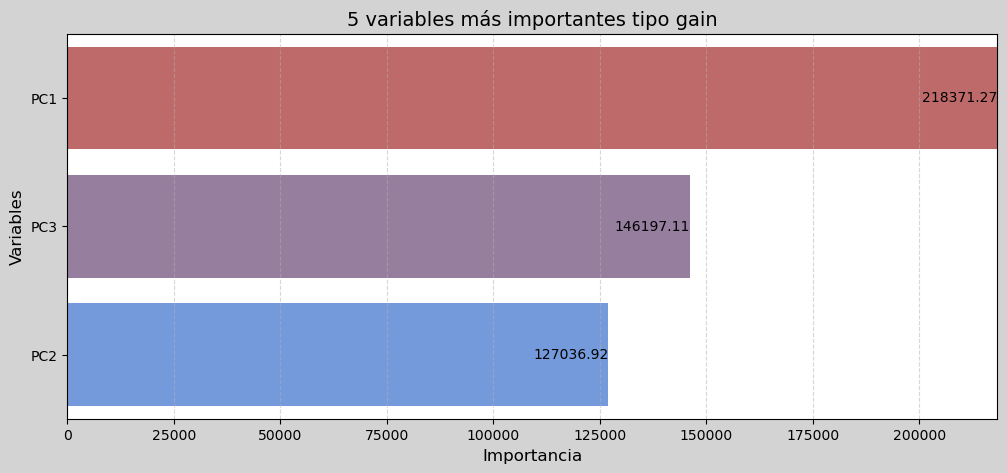

R2: 0.3196


In [12]:
Top3_X_componentes = X_componentes.iloc[:, :3]

XC3_train, XC3_test, y_train, y_test = train_test_split(Top3_X_componentes, y, test_size=0.2, random_state=42)

xgboost(XC3_train, XC3_test, y_train, y_test)

# Conclusiones